# Phishing URL Dataset Analysis

In [1]:
# !pip install m2cgen

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve
)
import joblib
import m2cgen as m2c

### Load the precomputed dataset

In [2]:
ls

Analysis.ipynb             package.json
SimpleExtension/           phishing_analysis 2.ipynb
data_analysis/             phishing_analysis.ipynb
datasets/                  rf_model.json
node_modules/              rf_model.pkl
package-lock.json          trainer.py


In [25]:
df = pd.read_csv("datasets/features.csv")
X = df.drop(["label","url"], axis=1)

#TODO: delete this if we want the url length because we already have the domain length
# X = df.drop(["label","url","url_length"], axis=1)

y = df["label"]

In [26]:
df

,url,url_length,dot_count,has_at,special_char_count,entropy,suspicious_keywords,subdomain_length,is_free_hosting,has_hyphen,...,fetchCount,xhrCount,wsCount,scriptInjectionCount,eventListenerCount,domMutationCount,attributeMutationCount,pageLoadTime,memoryUsed,label
0,https://bit.ly/3C67RTD,22,1,0,0,2.584963,0,0,0,0,...,0,0,0,0,0,0,0,6122.0,10000000,1
1,https://prod-rd-10040.firebaseapp.com/,38,2,0,2,3.952303,0,13,0,1,...,0,2,0,2,143,0,0,6437.0,19300000,1
2,https://blues.org,17,1,0,0,3.169925,0,0,0,0,...,2,4,0,5,562,5,0,9974.0,16100000,0
3,http://farmerregistry.co.in,27,2,0,0,3.621928,0,14,0,0,...,0,0,0,0,0,0,0,6021.0,10000000,0
4,https://mediacombb-100205.weeblysite.com/,41,2,0,1,4.054229,0,17,1,1,...,0,0,0,0,0,0,0,6029.0,10000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4394,https://www.eventbrite.com/signin/?referrer=%2F,47,2,0,2,3.419382,1,3,0,0,...,0,0,0,0,0,1,0,10692.2,50400000,0
4395,https://www.paloaltonetworks.com/,33,2,0,0,3.584963,0,3,0,0,...,0,0,0,0,0,1,0,12374.2,10000000,0
4396,https://mirait.firebaseapp.com/,31,2,0,0,3.572624,0,6,0,0,...,0,0,0,0,0,0,0,6012.4,10000000,1
4397,https://docs.google.com/presentation/d/e/2PACX...,175,2,0,9,2.973557,0,4,0,0,...,0,0,0,0,0,0,0,6485.6,10000000,1


### 1. Optimize n_estimators via OOB error

In [27]:
tree_range = list(range(10, 301, 10))
oob_errors = []
for n in tree_range:
    rf = RandomForestClassifier(n_estimators=n, oob_score=True, n_jobs=-1, random_state=42)
    rf.fit(X, y)
    oob_errors.append(1 - rf.oob_score_)

/opt/anaconda3/envs/TaskLighthouseENV/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/envs/TaskLighthouseENV/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [28]:
# verify labels
print(y.value_counts())


label
0    2718
1    1681
Name: count, dtype: int64


draw the data

In [7]:
# min_error = min(oob_errors)
# tolerance = 0.005  # Acceptable margin from minimum

# # Find the number of trees which it's error tends to be stable and close to the minimum 
# # by defining a sliding window size and approve that every point in that tree slice must be at most tolerance worse 
# #than the best error ever seen.
# window_size = 10

# # Find the first region near the minimum that is stable
# best_n = tree_range[-1]  # fallback to max n
# for i in range(len(oob_errors) - window_size + 1):
#     window = oob_errors[i:i + window_size]
#     if (np.max(window) - min_error <= tolerance):
#         best_n = tree_range[i + window_size - 1]
#         break
        
# plt.figure()
# plt.plot(tree_range, oob_errors, label="OOB Error")
# plt.axvline(best_n, color='red', linestyle='--', label=f"Selected n = {best_n}")
# plt.title("OOB Error vs. Number of Trees")
# plt.xlabel("Number of Trees")
# plt.ylabel("OOB Error")
# plt.legend()
# plt.show()

In [8]:
# best_n

In [9]:
# oob_errors[tree_range.index(best_n)]

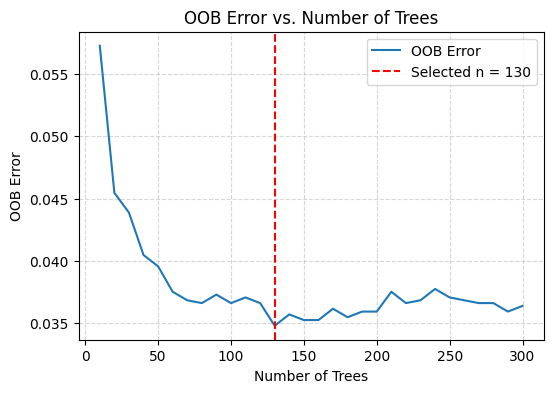

In [29]:
# find the global minimum
best_idx = np.argmin(oob_errors)
best_n = tree_range[best_idx]
        
plt.figure(figsize=(6, 4))
plt.plot(tree_range, oob_errors, label="OOB Error")
plt.axvline(best_n, color='red', linestyle='--', label=f"Selected n = {best_n}")
plt.grid(True, linestyle='--', alpha=0.5)
plt.title("OOB Error vs. Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error")
plt.legend()
plt.show()

In [30]:
best_n

130

In [31]:
oob_errors[tree_range.index(best_n)]

0.03478063196180947

### 2. Feature importances

 Find out the most informative features

In [32]:
# calculate the importance score of each feature based on the informationgain
rf_sel = RandomForestClassifier(n_estimators=best_n, n_jobs=-1, random_state=42)
rf_sel.fit(X, y)
importances = rf_sel.feature_importances_
indices = np.argsort(importances)[::-1]

Draw the data

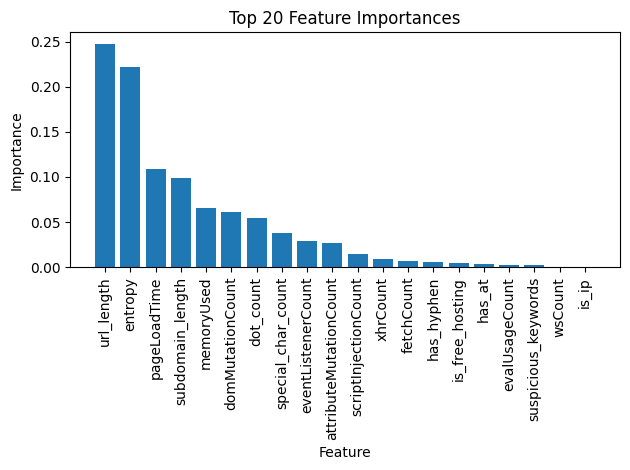

In [33]:
top_n = 20
plt.figure()
plt.bar(range(top_n), importances[indices][:top_n])
plt.xticks(range(top_n), [X.columns[i] for i in indices[:top_n]], rotation=90)
plt.title("Top 20 Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### 3. Feature Selection

### 3.1. Eliminate by feature–feature correlations

In [38]:
corr = X.corr().abs() # correlation matrix

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find index pairs where correlation bigger then 0.75
high_corr_pairs = [
    (upper.columns[i], upper.columns[j], upper.iat[i, j])
    for i in range(len(upper.columns))
    for j in range(i+1, len(upper.columns))
    if upper.iat[i, j] >= 0.75
]

print("Feature pairs with |r| bigger then 0.75:\n")
for f1, f2, r in high_corr_pairs:
    print(f"* feature {f1:20s} is highly correlated with {f2:20s} : r = {r:.3f}")


Feature pairs with |r| bigger then 0.75:

* feature url_length           is highly correlated with special_char_count   : r = 0.901
* feature suspicious_keywords  is highly correlated with is_ip                : r = 0.757


1) We will drop special_char_count sing we have already seen that url_length is the 1st importance feature, so special_char_count adds almost no new information.
2) We will drop the is_ip since normaly rarely an IP-based URL also contains suspicious words (two ways to catch anomalies in the host). suspicious_keywords has a bit higher importance then is_ip.

#### Drop correlated columns

In [39]:
to_drop = ["special_char_count", "is_ip"]
X_reduced = X.drop(columns=to_drop)

# Retain all features ordered by importance
orig_order = [X.columns[i] for i in indices]
ordered_feats = [f for f in orig_order if f in X_reduced.columns]

### 3.2 Wrapper-Based Feature Selection

We care about making the TPR >= 0.98 and minimizing the FPR.
We want to choose the smallest feature‐set that minimizes false alerts under this recall constraint ensuring that the vast majority of phishing attempts are correctly identified.
So for each k, we compute the ROC curve and find the FPR at the point where TPR ≥ 0.98 to return the k where FPR is the lowest.

Build models on the top k features for k = 1…N and cross‐validate each k

In [62]:
# Define number of features to evaluate
ks = list(range(1, len(ordered_feats) + 1))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for k in ks:
    feats = ordered_feats[:k] 
    oof_true, oof_prob = [], []  # Collect out-of-fold labels and predicted probabilities

    for tr_idx, te_idx in skf.split(X_reduced[feats], y):
        clf = RandomForestClassifier(n_estimators=best_n, random_state=42)
        clf.fit(X_reduced.iloc[tr_idx][feats], y[tr_idx])
        probs = clf.predict_proba(X_reduced.iloc[te_idx][feats])[:, 1]

        oof_true.extend(y[te_idx])
        oof_prob.extend(probs)

    # Compute ROC curve for all predictions
    fpr, tpr, thresholds = roc_curve(oof_true, oof_prob)

    # Find first threshold where TPR ≥ 98%
    idx98 = np.argmax(tpr >= 0.98)
    threshold_98 = thresholds[idx98]
    fpr_98 = fpr[idx98]

    results.append((k, threshold_98, fpr_98))

best_k, best_thr, best_fpr = min(results, key=lambda x: x[2])

Draw the data

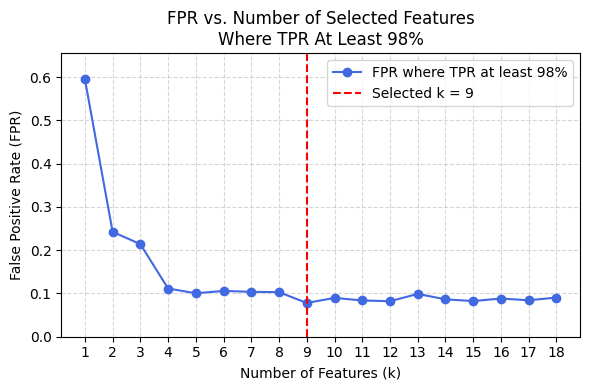

In [63]:
ks, thresholds, fprs = zip(*results)

plt.figure(figsize=(6, 4))
plt.plot(ks, fprs, marker='o', color='royalblue', label="FPR where TPR at least 98%")
plt.axvline(best_k, color='red', linestyle='--', label=f"Selected k = {best_k}")
plt.title("FPR vs. Number of Selected Features\nWhere TPR At Least 98%")
plt.xlabel("Number of Features (k)")
plt.ylabel("False Positive Rate (FPR)")
plt.ylim(0, max(fprs)*1.1)
plt.xticks(ks)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

We Choose the smallest k whose FPR where TPR-98% is the lowest.

In [42]:
print(f"Selected k = {best_k} features")
print(f"Threshold achieving TPR at least 98% : {best_thr:.3f}")
print(f"corresponding FPR: {best_fpr:.3f}")

Selected k = 9 features
Threshold achieving TPR at least 98% : 0.223
corresponding FPR: 0.078


Draw the ROC curve

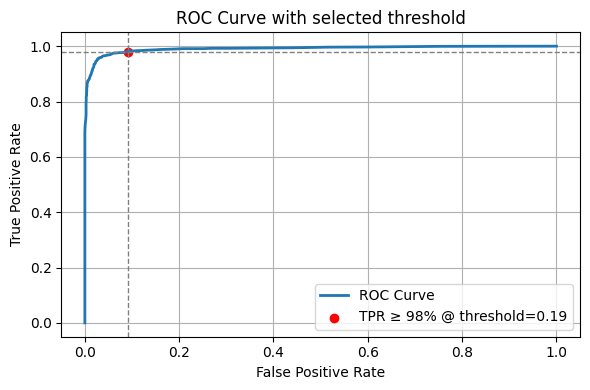

In [72]:
indices = np.where(tpr >= 0.98)[0]
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label="ROC Curve", lw=2)

idx98 = indices[0]
# Protect threshold indexing (thresholds is always len-1 of tpr/fpr)
thr_idx = min(idx98, len(thresholds) - 1)

plt.scatter(fpr[idx98], tpr[idx98], color='red',
            label=f"TPR ≥ 98% @ threshold={thresholds[thr_idx]:.2f}")
plt.axvline(x=fpr[idx98], linestyle='--', color='gray', lw=1)
plt.axhline(y=tpr[idx98], linestyle='--', color='gray', lw=1)

plt.title(f"ROC Curve with selected threshold")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
<!-- ### 3.2. Select Features by MAE -->

<!-- We will select the features involved in the classifier producing the lowest mean absolute error (MAE). -->

<!-- #### MAE vs number of selected features -->

In [43]:
# plt.figure()
# plt.plot(ks, mae_scores)
# plt.title("MAE vs. Number of Features")
# plt.xlabel("Number of Selected Features")
# plt.ylabel("MAE")
# plt.show()

In [44]:
# best_k = ks[np.argmin(mae_scores)]
# best_k

<!-- MAE minimises if 4 features are considered in the subset. Meaning that if we will select more then 4 features for the classification,
MAE will not decrease significantly.  -->

#### Select the optimal subset among 20 features.

In [45]:
selected_features = ordered_feats[:best_k]
print("selected_features: ", selected_features)

X_sel = X_reduced[selected_features]

selected_features:  ['url_length', 'entropy', 'pageLoadTime', 'subdomain_length', 'memoryUsed', 'domMutationCount', 'dot_count', 'eventListenerCount', 'attributeMutationCount']


### 4. ROC curve using the final selected features and model

We will check the usage of different thresholds from 0 to 1 since different threshold for classification can
lead to different performance of the classifier. 
ROC curve will be used for evaluation of the effectiveness of each threshold, comparing false positive (FP) rate versus 
truepositive (TP) rate across a range of thresholds.

Decided to use 5-folds for evaluation

In [46]:
feats = ordered_feats[:best_k]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_true, oof_prob = [], []

In [47]:
for tr_idx, te_idx in skf.split(X_sel[feats], y):
    clf = RandomForestClassifier(n_estimators=best_n, random_state=42)
    clf.fit(X_sel.iloc[tr_idx][feats], y[tr_idx])
    probs = clf.predict_proba(X_sel.iloc[te_idx][feats])[:, 1]
    oof_true.extend(y[te_idx])
    oof_prob.extend(probs)

# Plot the ROC curve
fpr_arr, tpr_arr, thr_arr = roc_curve(oof_true, oof_prob)

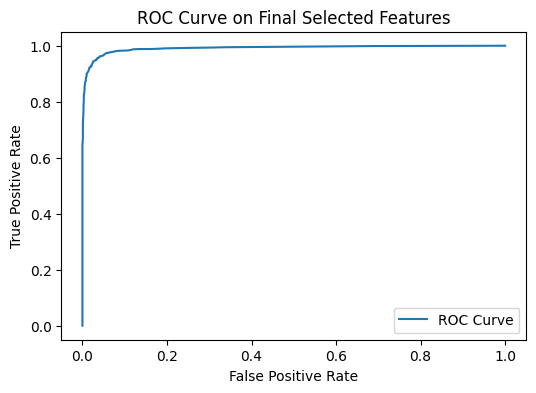

In [48]:
plt.figure(figsize=(6, 4))
plt.plot(fpr_arr, tpr_arr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Final Selected Features")
plt.legend()
plt.show()

In [54]:
# print("Optimal threshold: ", best_thr)

In [60]:
# Find all thresholds where TPR >= 0.98
indices = np.where(tpr_arr >= 0.98)[0]
# Choose the one with the lowest FPR among them
best_idx = indices[np.argmin(fpr_arr[indices])]
best_thr = thr_arr[best_idx]
best_tpr = tpr_arr[best_idx]
best_fpr = fpr_arr[best_idx]

print("Threshold satisfying TPR ≥ 98%:", best_thr)
print("TPR:", best_tpr)
print("FPR:", best_fpr)


Threshold satisfying TPR ≥ 98%: 0.2230769230769231
TPR: 0.9803688280785247
FPR: 0.07799852832965416


### 5. Final Cross-Validated Evaluation (Fixed Features & Threshold)

Decided to use 5-folds for evaluation

In [50]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

precisions = []
recalls = []
f1s = []
fprs = []
tprs = []

for train_idx, test_idx in skf.split(X_sel, y):
    X_train, X_test = X_sel.iloc[train_idx], X_sel.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestClassifier(n_estimators=best_n, random_state=42)
    model.fit(X_train, y_train)

    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= best_thr).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    tp, fn, fp, tn = cm[1,1], cm[1,0], cm[0,1], cm[0,0]

    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    tprs.append(tp / (tp + fn))
    fprs.append(fp / (fp + tn))

In [51]:
# Print mean scores
print("Cross-Validation Performance:\n")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall (TPR): {np.mean(tprs):.4f}")
print(f"False Positive Rate (FPR): {np.mean(fprs):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

Cross-Validation Performance:

Precision: 0.8861
Recall (TPR): 0.9804
False Positive Rate (FPR): 0.0780
F1 Score: 0.9308


## DELETE AFTER: Export the model to the extension!!

## Train the final model

In [29]:
final_model = RandomForestClassifier(n_estimators=best_n, random_state=42)
final_model.fit(X_sel, y)

RandomForestClassifier(n_estimators=130, random_state=42)

1. save the model to a pkl file

In [30]:
joblib.dump(final_model, "rf_model.pkl")

['rf_model.pkl']

2. use m2cgen to emit JS

In [31]:
rf = joblib.load("rf_model.pkl")
js_code = m2c.export_to_javascript(rf, function_name="predictPhishScore")

# write it into the extension folder
with open("./SimpleExtension/predict_model.js", "w") as f:
    f.write(js_code)